# MCT4001 Scientific Computing in Python Session 9
![mct-banner](https://raw.githubusercontent.com/wiki/MCT-master/Guides/assets/img/mct-banner.jpg)

In [1]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time

#importing signal processing package from scipy (if not we have to specify scipy.signal)
from scipy import signal


# defining funtions that will be used in this notebook

def mySineSynth(freq, dur_ms, amp=1, pha=0, sr=48000):

    t = np.arange(0,dur_ms/1000,1/sr)
    s = amp*np.sin(2*np.pi*freq*t+pha)
    
    return s

def myPlotStem(signal,title):
    plt.figure(figsize=(10, 3))
    plt.stem(signal, use_line_collection=True)
    plt.grid(True)
    plt.xticks(range(0,signal.size))
    #plt.ylim([-1,1])
    plt.title(title)
    plt.show()

def myPlotLine(signal,title):
    plt.figure(figsize=(10, 3))
    plt.plot(signal)
    plt.grid(True)
    #plt.ylim([-1,1])
    plt.title(title)
    plt.show()
    
def mySpectrogram(s,sr,title):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.show()

def myWaveform(s,sr,title):
    plt.figure(figsize=(10, 3))
    librosa.display.waveplot(s, sr=sr)
    plt.title(title)
    plt.show()

def myFiltResponse(b,a,sr):
    w, h = scipy.signal.freqz(b,a)
    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')
    ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Normalized Frequency')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w/math.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()


In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

## 1. Matched Filter

A matched filter (FIR type) can identify a signal/pattern in an incoming stream of data. The coefficients of the filter are the same samples of the signal/pattern to detect but in reversed (flipped) order.

When the output of the filter is above a manually determined threshold, the signal has been detected (i.e. the last sample of the signal/patter has just entered the filter).


[ 0.45  0.4  -0.35 -0.3   0.25  0.2  -0.15 -0.1 ]
[-0.1  -0.15  0.2   0.25 -0.3  -0.35  0.4   0.45]


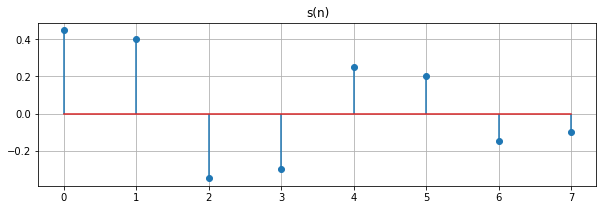

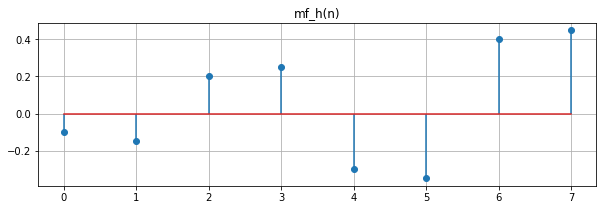

In [3]:
# signal/pattern to find
s = np.array([0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])

# desgning matched filter impulse response
mf_h = s[::-1]

#alternative is np.fliplr(sig) or flip(sig, 1) but require 2D array
#s = np.reshape(s,[1,s.size])
#mf_h = np.fliplr(s)

print(s)
print(mf_h)

myPlotStem(s, 's(n)')
myPlotStem(mf_h, 'mf_h(n)')


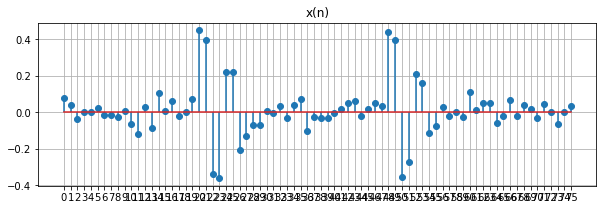

In [4]:
# creating a long signal which includes multiple copies of the signal to find

x = np.zeros([1,20])
x = np.append(x,s)
x = np.append(x,np.zeros([1,20]))
x = np.append(x,s)
x = np.append(x,np.zeros([1,20]))

# adding noise
x = x + 0.05*np.random.randn(x.size)

myPlotStem(x, 'x(n)')


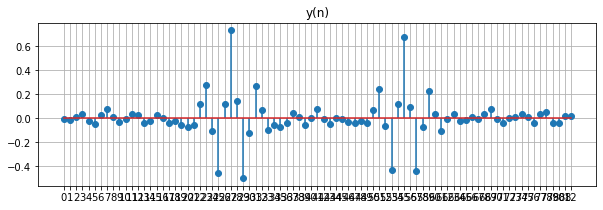

In [5]:
# computing matched filter output

y = np.convolve(x,mf_h)

#alternative
#y = signal.lfilter(mf_h, 1, x)

myPlotStem(y, 'y(n)')

In [6]:
# manually setting a threshold
# and using it to find prersence of s at the output of the matched filter

threshold = 0.6

s_detect = np.argwhere(y > threshold)

print('s detected at')
print(s_detect)

s detected at
[[27]
 [55]]


## 2. Cascade and Parallel of Filters

Computing output and overall response of cascade or parallel of filters. This is useful to achieve "composite" filters with a more complex response starting from simple one. This is quite common with IIR (uised in the  examples), but the same method applief for FIR.


### 2.1 Cascade

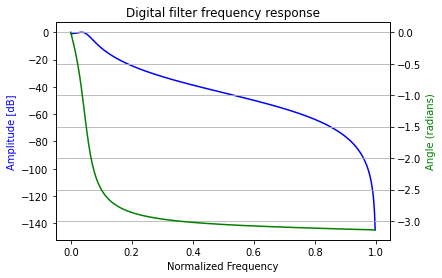

In [7]:
#second filter second order low pass
sr = 48000
order = 2
fc = 0.05
b1, a1 = signal.cheby1(2, 1, fc, 'low', analog=False)

# displaying response
myFiltResponse(b1,a1,sr)

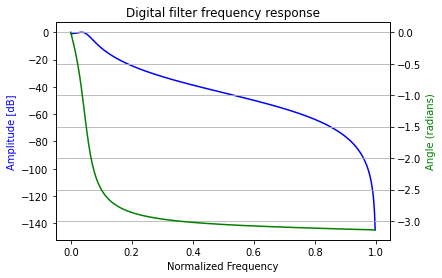

In [8]:
#second filter second order low pass
sr = 48000
order = 2
fc = 0.05
b2, a2 = signal.cheby1(2, 1, fc, 'low', analog=False)

# displaying response
myFiltResponse(b2,a2,sr)

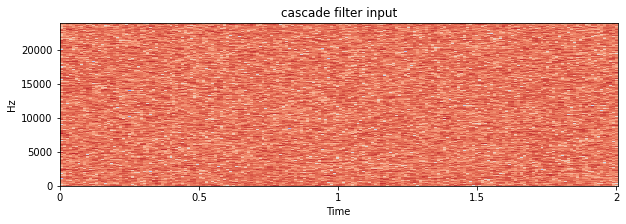

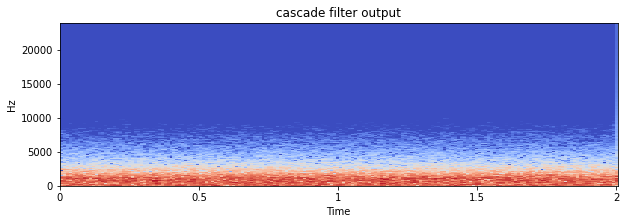

In [9]:
#applying the cascade
x = np.random.normal(0, 0.1, 2*sr)

# computing the output
y = signal.lfilter(b1, a1, x)
y = signal.lfilter(b2, a2, y)

#displaying results
mySpectrogram(x, sr, 'cascade filter input')
mySpectrogram(y, sr, 'cascade filter output')

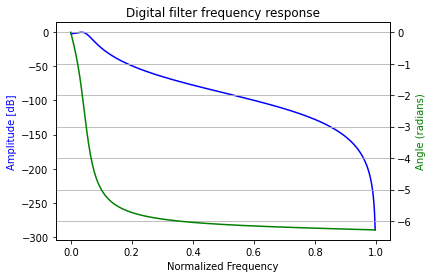

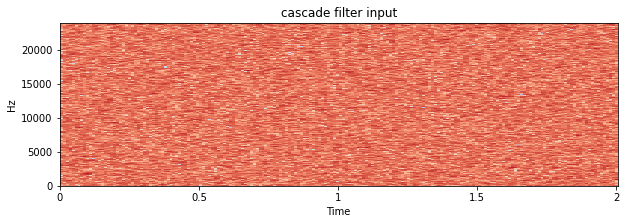

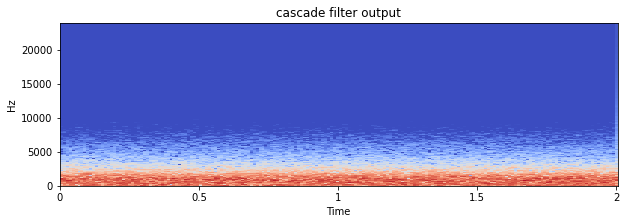

In [10]:
# to compute the cascade it is sufficnent
# to perform the convolution between
# the two numerators (a) and denominators (b) coefficients

cascade_a = np.convolve(a1,a2)
cascade_b = np.convolve(b1,b2)

myFiltResponse(cascade_b,cascade_a,sr)

#applying the cascade
x = np.random.normal(0, 0.1, 2*sr)

# computing the output
y = signal.lfilter(cascade_b, cascade_a, x)

#displaying results
mySpectrogram(x, sr, 'cascade filter input')
mySpectrogram(y, sr, 'cascade filter output')


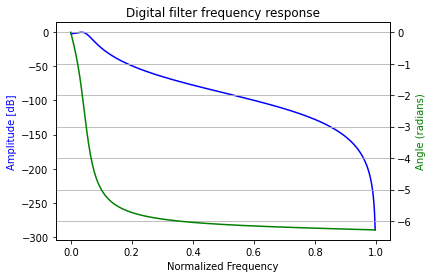

In [11]:
# to compute only  the response of the cascade
# we multiply the responses of the two filters (sum result of freqz)

w, h1 = signal.freqz(b1,a1)
w, h2 = signal.freqz(b2,a2)

h = h1 * h2

# the remaining is the code from myFiltResponse()
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')
ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Normalized Frequency')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/math.pi, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

original filter
[0.02347075 0.01265091 0.01265091 0.02347075]
[ 1.         -2.27428592  1.97927811 -0.63274888]


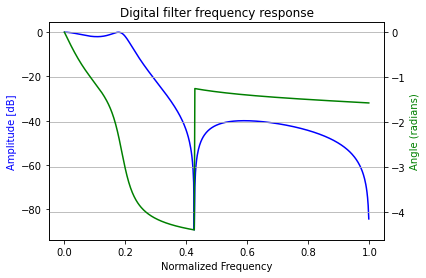

second order sections
[[ 0.02347075  0.02347075  0.          1.         -0.77233058  0.        ]
 [ 1.         -0.46099232  1.          1.         -1.50195534  0.81927207]]
[0.02347075 0.02347075 0.        ]
[ 1.         -0.77233058  0.        ]


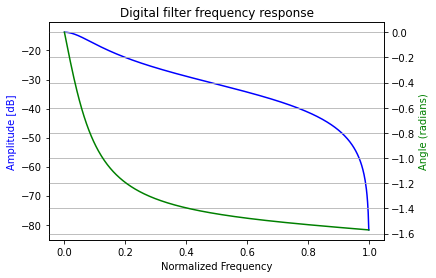

[ 1.         -0.46099232  1.        ]
[ 1.         -1.50195534  0.81927207]


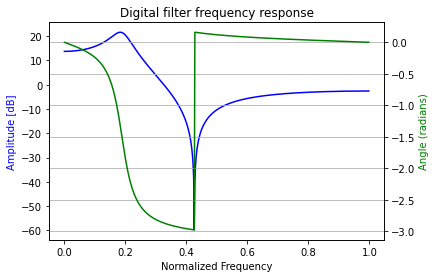

In [12]:
# at times it may be convenient to convert
# a long filter (either FIR or IIR) into a cascade of second order IIRs
# (this is recommended only if necessary, eg in PD we have only biquad)
# the drawback is a drop in numerical precision (often negligible)

# designing low pass IIR filter with iirdesign (we cannot specify the order)

sr = 48000
wp = 0.2 # passband edge frequency
ws = 0.4 # stopband edge frewuency
gpass = 2 # maximum loss in the passband (dB).
gstop = 40 # minimum attenuation in the stopband (dB).

[b,a] = signal.iirdesign(wp, ws, gpass, gstop)

sos = signal.tf2sos(b,a)

print('original filter')
print(b)
print(a)
myFiltResponse(b,a,sr)

signal.sos2tf(sos)
print('second order sections')
print(sos)

# in second order representation a and b are arranged  as follow in a single array 
# [b0,b1,b2,a0,a1,a2]
for section in sos:
    b = section[0:3]
    a = section[3:6]
    print(b)
    print(a)
    myFiltResponse(b,a,sr)
    
# generally in scipy  we can work with sos representation
# we can apply  a filter in sos form using sosfilt()


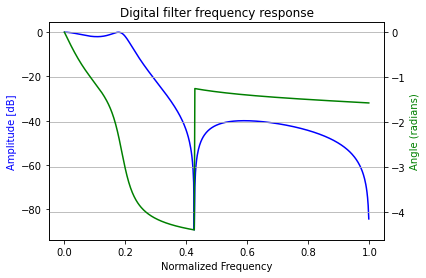

In [13]:
# further checking that the cascade of the two biquad
# matches the response of the original filter

# the code below works only if starting from a 4th order filter
b1 = sos[0,0:3]
a1 = sos[0,3:6]
b2 = sos[1,0:3]
a2 = sos[1,3:6]

cascade_a = np.convolve(a1,a2)
cascade_b = np.convolve(b1,b2)

myFiltResponse(cascade_b,cascade_a,sr)

### 2.1 Parallel

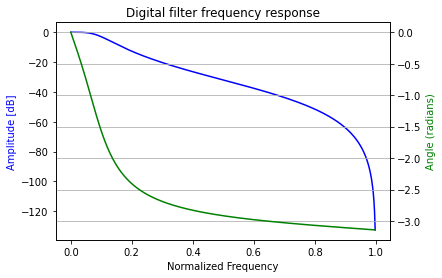

In [14]:
#first filter second order low pass
sr = 48000
order = 2
fc = 0.1
b1,a1 = signal.butter(order, fc, 'low', analog=False)

# displaying response
myFiltResponse(b1,a1,sr)


/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_77203/219357115.py:61: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')


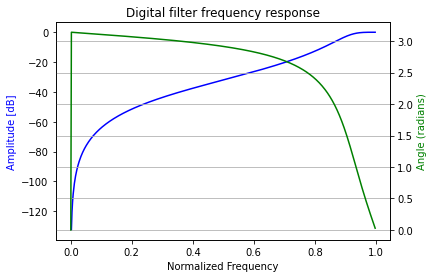

In [15]:
#second filter second order high pass
sr = 48000
order = 2
fc = 0.9
b2,a2 = signal.butter(order, fc, 'high', analog=False)

# displaying response
myFiltResponse(b2,a2,sr)


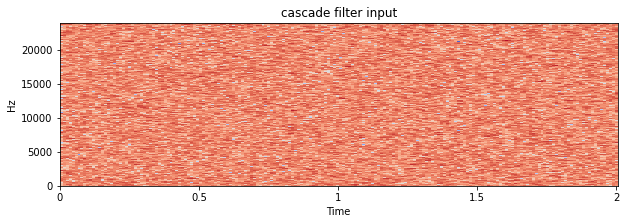

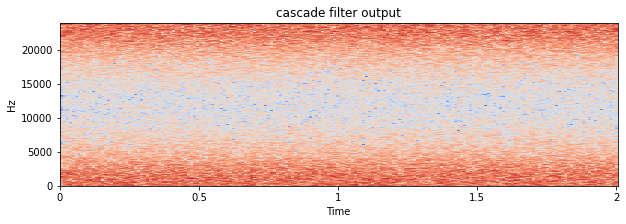

In [16]:
#applying the cascade
x = np.random.normal(0, 0.1, 2*sr)

# computing the output
y1 = signal.lfilter(b1, a1, x)
y2 = signal.lfilter(b2, a2, x)

y = y1 + y2

#displaying results
mySpectrogram(x, sr, 'cascade filter input')
mySpectrogram(y, sr, 'cascade filter output')

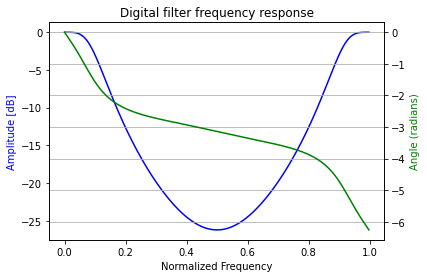

In [17]:
# to compute the response of the parallel
# we sum the responses of the two filters (sum result os freqz)

w, h1 = signal.freqz(b1,a1)
w, h2 = signal.freqz(b2,a2)

h = h1 + h2

# the remaining is the code from myFiltResponse()
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')
ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Normalized Frequency')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/math.pi, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

## 3. Filtering noisy signals & DC removal

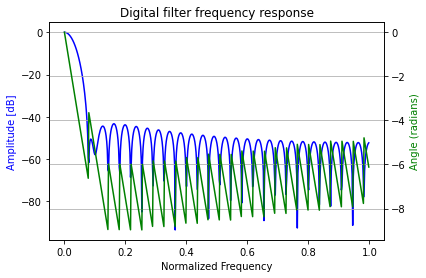

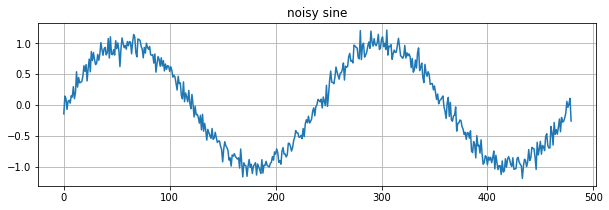

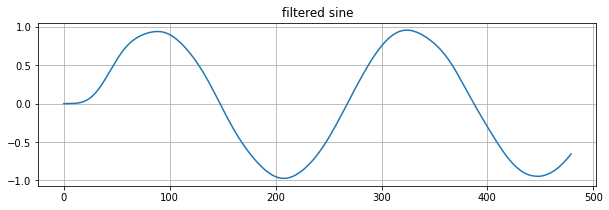

In [18]:
# designing low pass FIR filter with firwin

sr = 48000
numtaps = 55
fc = 0.01 
b = signal.firwin(numtaps, fc, pass_zero=True)

# displaying response
myFiltResponse(b,1,sr)

# noise sine signal
x = mySineSynth(freq=200, dur_ms=10, sr=sr) + np.random.normal(0, 0.1, int(0.01*sr))

myPlotLine(x,'noisy sine')

# computing the output (this can be done also via convolution, is the same operation for a FIR)
y = signal.lfilter(b, 1, x)

myPlotLine(y,'filtered sine')


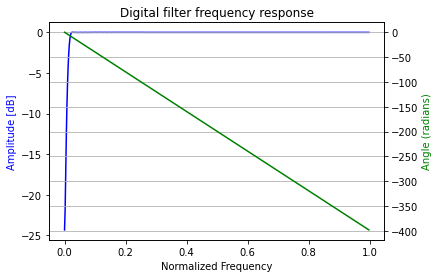

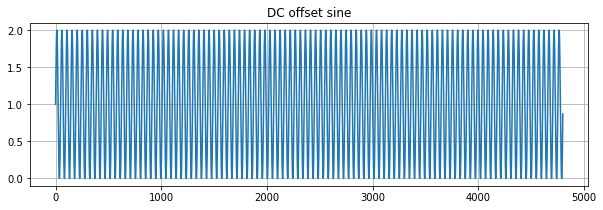

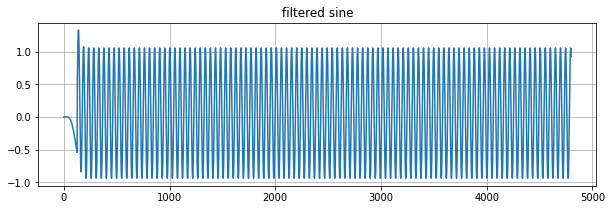

In [19]:
# designing high pass FIR filter with firwin

sr = 48000
numtaps = 255
fc = 0.01
b = signal.firwin(numtaps, fc, pass_zero=False)

# displaying response
myFiltResponse(b,1,sr)

# sine signal with DC offset
x = mySineSynth(freq=1000, dur_ms=100, sr=sr) + 1

myPlotLine(x,'DC offset sine')

# computing the output (this can be done also via convolution, is the same operation for a FIR)
y = signal.lfilter(b, 1, x)


myPlotLine(y,'filtered sine')


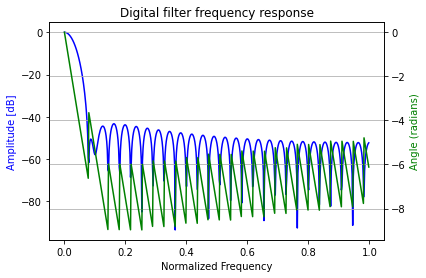

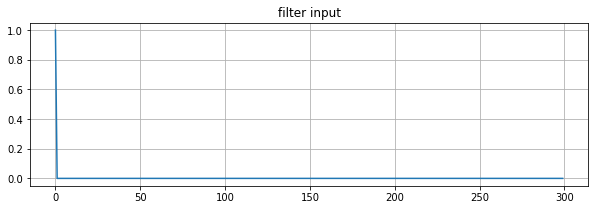

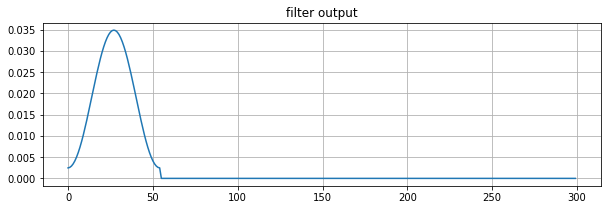

In [20]:
# designing low pass FIR filter with firwin and displaying impulse response

sr = 48000
numtaps = 55
fc = 0.01 
b = signal.firwin(numtaps, fc, pass_zero=True)

# displaying response
myFiltResponse(b,1,sr)

# impulse
x = signal.unit_impulse(300)

myPlotLine(x,'filter input')

# computing the output (this can be done also via convolution, is the same operation for a FIR)
y = signal.lfilter(b, 1, x)

myPlotLine(y,'filter output')


## 3. Comb  Filters 

A [comb filter](https://en.wikipedia.org/wiki/Comb_filter) is a filter implemented by adding a delayed version of a signal to itself, causing constructive and destructive interference. The frequency response of a comb filter consists of a series of regularly spaced notches, giving the appearance of a comb.

In [21]:
# load filter input
sr = 48000
x, sr = librosa.load('./files/Loop.wav', sr) 

241
241


/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_77203/219357115.py:61: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')


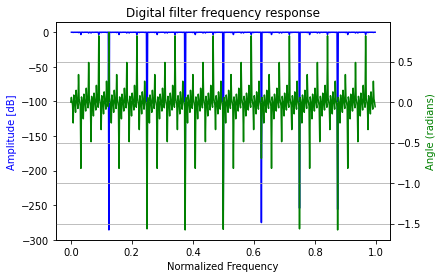

In [22]:
# notch comb

f0 = 200.0  # frequency to be removed from signal (Hz)
Q = 30.0  # quality factor

# design notching filter
b,a = signal.iircomb(f0, Q, ftype='notch', fs=sr)

print(a.size)
print(b.size)

myFiltResponse(b,a,sr)

y = signal.lfilter(b,a,x)

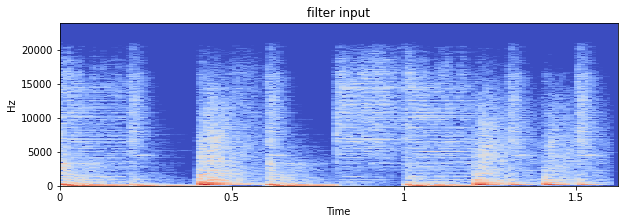

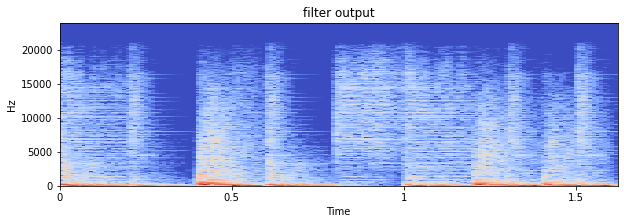

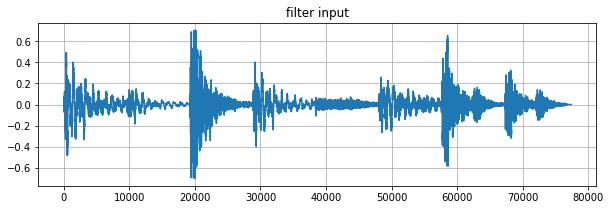

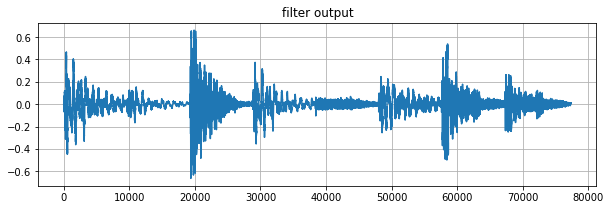

In [23]:
mySpectrogram(x, sr, 'filter input')
mySpectrogram(y, sr, 'filter output')
myPlotLine(x,'filter input')
myPlotLine(y,'filter output')
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()


25
25


/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_77203/219357115.py:61: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')


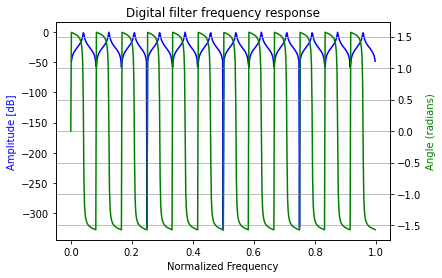

In [24]:
# peak comb

f0 = 2000.0  # frequency to be retained (Hz)
Q = 30.0  # quality factor

# design peaking filter
b,a = signal.iircomb(f0, Q, ftype='peak', fs=sr)

print(a.size)
print(b.size)

myFiltResponse(b,a,sr)

y = signal.lfilter(b,a,x)

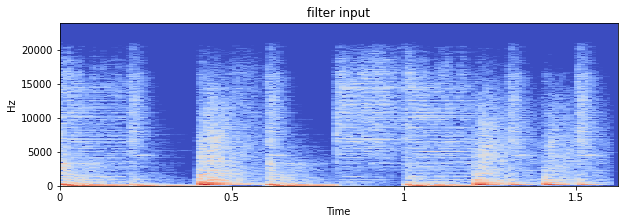

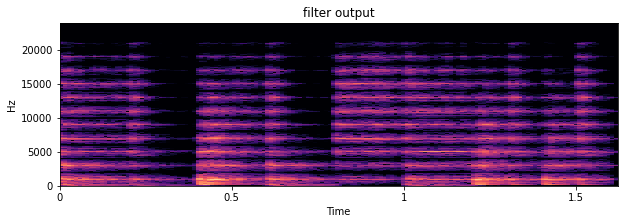

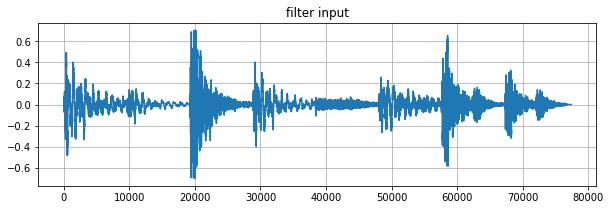

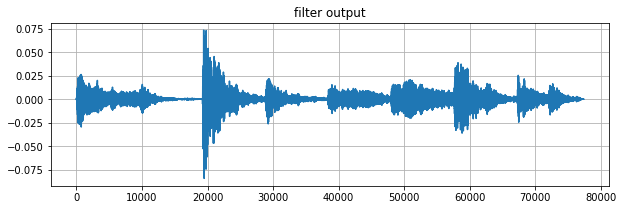

In [25]:
mySpectrogram(x, sr, 'filter input')
mySpectrogram(y, sr, 'filter output')
myPlotLine(x,'filter input')
myPlotLine(y,'filter output')
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()

## 4. All-pass Filters

An [all-pass filter](https://en.wikipedia.org/wiki/All-pass_filter) is a signal processing filter that passes all frequencies equally in gain, but changes the phase relationship among various frequencies. Most types of filter reduce the amplitude (i.e. the magnitude) of the signal applied to it for some values of frequency, whereas the all-pass filter allows all frequencies through without changes in level.

In [26]:
# function to design all pass
def allpass(delay, gain):
    b = np.zeros(delay)
    b[0] = gain
    b[delay-1] = 1
    a = np.zeros(delay)
    a[0] = 1
    a[delay-1] = gain
    return b,a


[0.2 0.  0.  0.  0.  0.  0.  0.  0.  1. ]
[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.2]


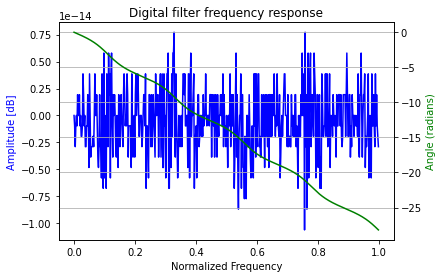

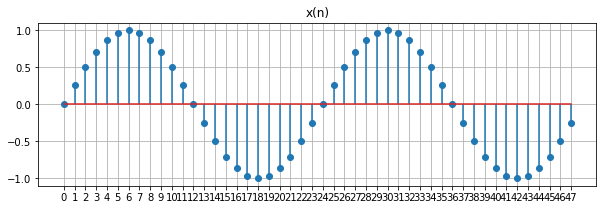

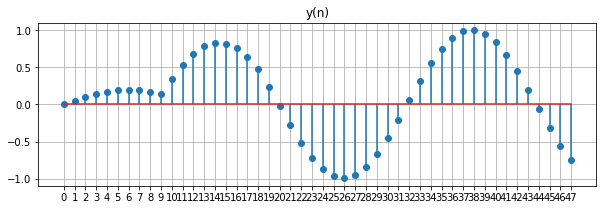

In [27]:
delay = 10  # delay in samples
gain = 0.2  # linear gain

x = mySineSynth(freq=2000, dur_ms=1, sr=sr)

# design all pass
b,a = allpass(delay, gain)

print(b)
print(a)

myFiltResponse(b,a,sr)

y = signal.lfilter(b,a,x)

myPlotStem(x, 'x(n)')
myPlotStem(y, 'y(n)')

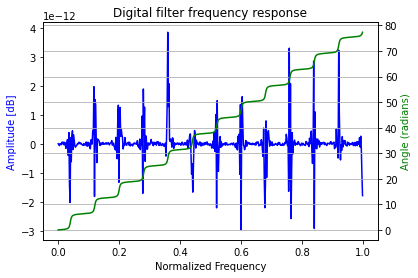

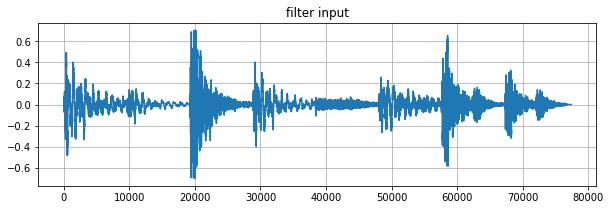

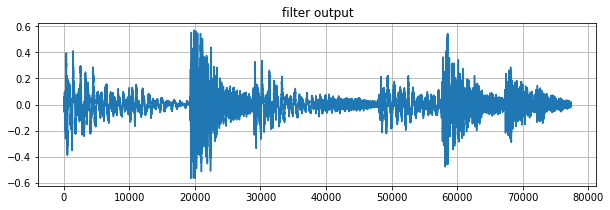

In [28]:
# load filter input
sr = 48000
x, sr = librosa.load('./files/Loop.wav', sr) 

delay = 1000  # delay in samples
gain = 0.8  # linear gain

# design all pass
b,a = allpass(delay, gain)

myFiltResponse(b,a,sr)

y = signal.lfilter(b,a,x)

myPlotLine(x,'filter input')
myPlotLine(y,'filter output')
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()